# Evaluating DeepLiftSHAP

## Imports and Setup

In [1]:
import os
import platform
from pathlib import Path

# for when on NCC to be able to import local packages
os.chdir(os.path.expanduser("~/l3_project"))
Path.cwd()

PosixPath('/home2/jgcw74/l3_project')

In [2]:
import helpers
import dataset_processing.eurosat

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [14]:
from captum.attr import DeepLiftShap
from safetensors.torch import load_model
import torchvision.transforms.v2 as transforms
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe MIG 1g.10gb to use as a cuda device.
Using cuda as torch device.


In [5]:
np_rng = np.random.default_rng(42)
_ = torch.manual_seed(42)

# EuroSAT (RGB) Dataset

In [6]:
base_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),  # scaling handles by normalise below
    dataset_processing.core.RSNormaliseTransform(0, 2750),
    # normalise to [0, 1] (based on maximums used in original paper)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True),  # shift to mean 0 and std 1

    # scale as expected by ResNet (see https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights)
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
])
wrapped_base_transforms = dataset_processing.core.tensor_dict_transform_wrapper(base_transforms)

eurosat_val_ds = dataset_processing.eurosat.get_dataset(
    "val", bands=("B04", "B03", "B02"),  # RGB bands
    transforms=wrapped_base_transforms, download=False
)

print(f"There are {len(eurosat_val_ds)} validation samples.")
print("Image dimensions and label:", eurosat_val_ds[0]["image"].size(), eurosat_val_ds[0]["label"])

There are 5400 validation samples.
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)


In [7]:
val_dataloader = torch.utils.data.DataLoader(
    eurosat_val_ds, batch_size=32, num_workers=4, shuffle=False, drop_last=False
)
validation_iterator = iter(dataset_processing.core.cycle(val_dataloader))

In [36]:
def show_image(img: torch.Tensor):
    if img.min() < 0:
        img = (img + 1) / 2  # un-normalise
    img = np.transpose(img.cpu(), (1, 2, 0))  # move colour channel to end
    plt.imshow(img)
    plt.axis("off")

## ResNet 50

### Load Model

In [8]:
checkpoints_path = Path.cwd() / 'checkpoints'
assert checkpoints_path.exists()

In [9]:
all_resnet50_saved = list(checkpoints_path.glob('./resnet50/*.st'))
print(all_resnet50_saved)
latest_resnet50_path = max(all_resnet50_saved, key=os.path.getctime)
latest_resnet50_path

[PosixPath('/home2/jgcw74/l3_project/checkpoints/resnet50/FineTunedResNet50_final_weights(0.950).st'), PosixPath('/home2/jgcw74/l3_project/checkpoints/resnet50/FineTunedResNet50_final_ft_weights(0.989).st')]


PosixPath('/home2/jgcw74/l3_project/checkpoints/resnet50/FineTunedResNet50_final_ft_weights(0.989).st')

In [47]:
resnet50 = helpers.models.FineTunedResNet50(num_classes=len(eurosat_val_ds.classes)).to(device)

In [48]:
print('Missing/Unexpected keys:', load_model(resnet50, latest_resnet50_path, strict=True, device=device.type))

Missing/Unexpected keys: (set(), [])


### Run SHAP

In [49]:
deep_shap_explainer = DeepLiftShap(resnet50, multiply_by_inputs=True)  # global attribution

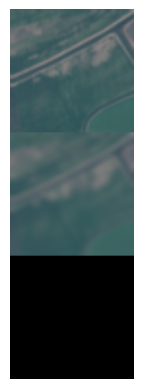

In [50]:
img_to_explain = eurosat_val_ds[1]["image"].to(device)
blurred_img = transforms.functional.gaussian_blur_image(img_to_explain, kernel_size=15, sigma=10)
black_img = torch.zeros_like(img_to_explain) - 1
show_image(torch.column_stack([img_to_explain, blurred_img, black_img]))

In [51]:
shap_vals = deep_shap_explainer.attribute(img_to_explain.unsqueeze(0), blurred_img.unsqueeze(0).repeat(5, 1, 1, 1),
                                          target=torch.tensor(0).to(device))

/home2/jgcw74/miniconda3/envs/sat_project/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


RuntimeError: A Module ReLU(inplace=True) was detected that does not contain some of the input/output attributes that are required for DeepLift computations. This can occur, for example, if your module is being used more than once in the network.Please, ensure that module is being used only once in the network.